<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
#from torchsummary import summary

import os
#from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


In [2]:
# @title Data Loading
if os.path.isdir('./Training'):
    !rm ./Training/ -d -r
    !rm ./Testing/ -d -r
    !rm ./Validation/ -d -r
try:
    from google.colab import files
    if not os.path.isfile('./.kaggle/kaggle.json'):
        print('Upload kaggle.json account information to download the dataset:')
        files.upload()
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json
except:
    print('Colab initialization failed')
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --force
!unzip -q brain-tumor-mri-dataset.zip 

Colab initialization failed
100%|███████████████████████████████████████▊| 148M/149M [00:03<00:00, 43.0MB/s]
100%|████████████████████████████████████████| 149M/149M [00:03<00:00, 41.4MB/s]


In [3]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
  os.mkdir('./Validation/')
  classes = os.listdir('./Training/')
  training_samples = []
  for i in classes:
    os.mkdir(f'./Validation/{i}/')
    files = os.listdir(f'./Training/{i}/')
    for f in files:
      training_samples.append(f'/{i}/{f}')
  random.shuffle(training_samples)
  validation_samples = training_samples[0:1100]
  training_samples = training_samples[1100:]
  for samp in validation_samples:
    os.rename(f'./Training{samp}', f'./Validation{samp}')


In [4]:
# @title Loading Model
Classifier = models.vgg19(weights='DEFAULT')
#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)
Classifier.to('cuda')
#summary(Classifier, (3, 256, 256))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

0 tensor([0, 1, 1, 0, 0, 2, 2, 2, 0, 1, 0, 0, 3, 2, 0, 2])
torch.Size([16, 3, 256, 256])


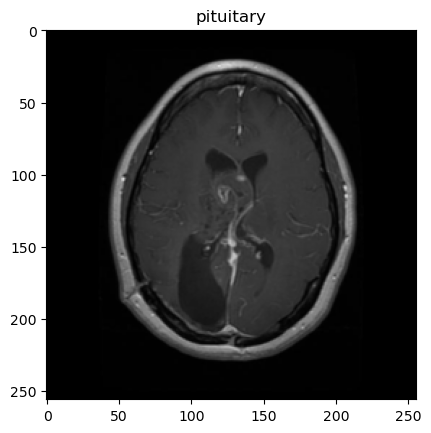

In [10]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=16, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=16, shuffle=True)

TestDataset = ImageFolder(root='./Testing/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TestLoader = DataLoader(TestDataset, batch_size=16, shuffle=True)

classes = os.listdir('./Training/')
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  print(images.shape)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [6]:
# Cross Entropy Loss for categorization
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(Classifier.parameters(), lr=0.005, momentum=.5)


def calc_accuracy(prediction, label):
    prediction = torch.argmax(prediction, axis=1)
    return (prediction == label).sum()/len(label) * 100

def train_plot(loss, acc, val_loss, val_acc):
    plt.figure(figsize=(20,20))
    plt.subplot(2,1,1)
    plt.title('Loss')
    plt.plot(loss, label='training')
    plt.plot(val_loss, label='validation')
    plt.legend()
    plt.subplot(2,1,2)
    plt.title('Accuracy')
    plt.plot(acc, label='training')
    plt.plot(val_acc, label='validation')
    plt.legend()
    
def one_epoch(epoch_index):
    current_loss = 0
    running_loss = 0
    val_running_loss = 0
    acc = []
    val_acc = []

    for i, data in enumerate(TrainingLoader):
        inputs, labels = data

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = Classifier(inputs)
        acc.append(calc_accuracy(outputs, labels))
        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        current_loss += loss.item()
        running_loss += loss.item()
        if i % 10 == 9:
            print(f'Epoch {epoch_index + 1}, Batch {i + 1}, Loss: {current_loss / 10:.3f}, Running Accuracy {sum(acc)/(i+1)}')
            current_loss = 0.0
    
    print(f'Epoch {epoch_index + 1}, Total Loss: {running_loss}, Total Accuracy: {sum(acc)/(i+1)}')
    print('Validating...')
    for j, data in enumerate(ValidationLoader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = Classifier(inputs)
        val_acc.append(calc_accuracy(outputs, labels))
        loss = loss_fn(outputs, labels)
        val_running_loss += loss.item()
    print(f'Epoch{epoch_index + 1}, Validation Loss: {val_running_loss}, Validation Accuracy {sum(val_acc)/(j+1)}')
    return running_loss, sum(acc)/(i+1), val_running_loss, sum(val_acc)/(j+1)

In [7]:
loss = []
val_loss = []
acc = []
val_acc = []
'''
for i in range(0,5):
    V = one_epoch(i)
    loss.append(V[0])
    acc.append(V[1].cpu())
    val_loss.append(V[2])
    val_acc.append(V[3].cpu())
    '''

/home/nicholas/anaconda3/envs/Neuro/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Batch 10, Loss: 1.203, Running Accuracy 48.125
Epoch 1, Batch 20, Loss: 0.956, Running Accuracy 55.9375
Epoch 1, Batch 30, Loss: 0.869, Running Accuracy 58.958335876464844
Epoch 1, Batch 40, Loss: 0.774, Running Accuracy 62.1875
Epoch 1, Batch 50, Loss: 0.577, Running Accuracy 65.625
Epoch 1, Batch 60, Loss: 0.555, Running Accuracy 67.8125
Epoch 1, Batch 70, Loss: 0.383, Running Accuracy 70.35713958740234
Epoch 1, Batch 80, Loss: 0.803, Running Accuracy 70.859375
Epoch 1, Batch 90, Loss: 0.564, Running Accuracy 71.80555725097656
Epoch 1, Batch 100, Loss: 0.350, Running Accuracy 73.4375
Epoch 1, Batch 110, Loss: 0.352, Running Accuracy 74.6022720336914
Epoch 1, Batch 120, Loss: 0.193, Running Accuracy 76.25000762939453
Epoch 1, Batch 130, Loss: 0.305, Running Accuracy 77.25961303710938
Epoch 1, Batch 140, Loss: 0.155, Running Accuracy 78.4375
Epoch 1, Batch 150, Loss: 0.233, Running Accuracy 79.33333587646484
Epoch 1, Batch 160, Loss: 0.397, Running Accuracy 79.5703125
Epoch 1,

Epoch 5, Batch 70, Loss: 0.001, Running Accuracy 99.82142639160156
Epoch 5, Batch 80, Loss: 0.061, Running Accuracy 99.765625
Epoch 5, Batch 90, Loss: 0.008, Running Accuracy 99.79167175292969
Epoch 5, Batch 100, Loss: 0.030, Running Accuracy 99.75
Epoch 5, Batch 110, Loss: 0.071, Running Accuracy 99.48863220214844
Epoch 5, Batch 120, Loss: 0.029, Running Accuracy 99.42708587646484
Epoch 5, Batch 130, Loss: 0.035, Running Accuracy 99.375
Epoch 5, Batch 140, Loss: 0.016, Running Accuracy 99.375
Epoch 5, Batch 150, Loss: 0.017, Running Accuracy 99.375
Epoch 5, Batch 160, Loss: 0.013, Running Accuracy 99.375
Epoch 5, Batch 170, Loss: 0.002, Running Accuracy 99.4117660522461
Epoch 5, Batch 180, Loss: 0.004, Running Accuracy 99.44445037841797
Epoch 5, Batch 190, Loss: 0.007, Running Accuracy 99.47368621826172
Epoch 5, Batch 200, Loss: 0.006, Running Accuracy 99.5
Epoch 5, Batch 210, Loss: 0.012, Running Accuracy 99.49404907226562
Epoch 5, Batch 220, Loss: 0.003, Running Accuracy 99.51704406

In [15]:
#train_plot(loss, acc, val_loss, val_acc) 
len(TrainingLoader.dataset)

4612

In [ ]:
class Brain_Classifier():
    # WIP!!!! Still building
    # Class to assist with training and evaluation of our Brain Tumor Classification model
    
    def __init__(self, model, train_dir='./Training', val_dir='./Validation', test_dir='./Testing'):
        self.Model = model
        
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.build_loader()
        
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.Model.parameters(), lr=0.005, momentum=.5)
        
    def build_loader(self):
        #Build the data loaders for training and evaluation
        data_transf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
        self.TrainData = DataLoader(ImageFolder(root=self.train_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        self.ValData = DataLoader(ImageFolder(root=self.val_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        self.TestData = DataLoader(ImageFolder(root=self.test_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        
    def run_epoch(self, train=False, data='validation'):
        if data == 'train': dataset = self.TrainData
        elif data == 'validation': dataset = self.ValData
                
        current_loss = 0
        for i, j in enumerate(dataset):
            if train: self.optimizer.zero_grad()
                
            inputs, labels = j
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            outputs = self.Model(inputs)
            loss = self.loss_fn(outputs, labels)
            if train: loss.backward(), self.optimizer.step()
            
            current_loss += loss.item()
        return current_loss / len(dataset.dataset)
    
    def train(self, n_epochs):
        train_loss = []
        for i in range(0, n_epochs):
            loss = self.run_epoch(train=True, data='train')
            train_loss.append(loss)
        print(train_loss)
        
A = Brain_Classifier(Classifier)
A.train(1)
        